[![Open in colab](colab.research.google.com/assets/colab-badge.svg)](https://github.com/marcos-vmiranda/pos-pucrj-mvp/blob/main/MVP_ML_MarcosMiranda.ipynb)


**PUC - Pós Graduação em Ciência de Dados e Analytics**
# MVP: *Machine Learning & Analytics*
- **Autor:** Marcos Vinícius de Miranda  
- **Data:** 27/08/2025
- **Matrícula:** 4052025001185
- **Dataset:** [Atrasos](https://github.com/marcos-vmiranda/pos-pucrj-mvp/blob/732bb70e9d90a4ebeac4e71f7ed4a645f6147fb6/atrasos_tratados.csv?raw=true)



## 1. Escopo, objetivo e definição do problema

Em uma base de distribuição de combustíveis é de grande importância que o atendimento seja feito ao longo do dia de maneira uniforme, a fim de evitar horários de pico que geram excesso de veículos e filas na base, causando insatisfação dos clientes. Os atrasos da chegada dos veículos em relação ao horário agendado prejudicam a eficiência da base, uma vez que a as baias de carregamento ficam vazias aguardando os veículo atrasados.

O objetivo desse projeto é desenvolver um modelo de classificação para prever se um veículo irá atrasar mais que 30 minutos (tempo padrão de tolerância), a partir de informações históricas das viagens de todos os veículos.

A aplicação desse modelo será na antecipação da chamada dos veículos que já estejam na base, em detrimento dos veículos que tenham previsão de atraso.

Essa aplicação é de grande valor para o negócio, pois irá gerar os seguintes benefícios:
  - Evitar que a base fique aguardando um veículo que provavelmente irá atrasar
  - Reduzir o tempo médio de permanência na unidade (TMPU), que é um indicador operacional importante
  - Aumentar a eficiência operacional da base, ou seja, permitir que mais veículos sejam carregados num mesmo tempo
  - Aumentar a taxa de ocupação das baias
  - Melhorar o nível de atendimentos dos clientes, um vez que as filas e os tempos de espera serão reduzidos



## 2. Preparação do ambiente
### 2.1 Instalação de pacotes
Verifica se os pacotes necessários para o funcionamento do projeto estão instalados


In [459]:
print("Versão do Python:", sys.version.split()[0])

# Verifica se os pacotes necessários estão instalados
# Se não estiverem, serão instaladas
packages = {'pandas', 'numpy', 'seaborn', 'matplotlib', 'sklearn', 'imblearn'}
for package in packages:
    if package not in sys.modules:
        print(f"Instalando pacote {package} ...")
        !pip install {package}


Versão do Python: 3.12.10



### 2.2. Importação das bibliotecas
Importa as bibliotecas que serão utilizadas no projeto

In [460]:
# Bibliotecas usadas
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import (MinMaxScaler,StandardScaler,RobustScaler)
from sklearn.model_selection import (train_test_split,StratifiedKFold,cross_val_score,GridSearchCV)
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,classification_report)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import (LogisticRegression,RidgeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier)
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE

### 2.3. Definição da seed global
Define uma semente global. Necessário para garantir reprodutibilidade dos resultados 

Faz com que os mesmos números aleatórios sejam gerados em todas as execuções.

In [461]:
seed = 7
np.random.seed(seed)

print("Seed global:", seed)

Seed global: 7


### 2.2 Funções

In [478]:
def avaliar_classificacao(y_true, y_pred, proba=None):
    # Calcula métricas de avaliação para problemas de classificação
    # parâmetros de entrada:
    #   y_true: rótulos verdadeiros
    #   y_pred: rótulos previstos pelo modelo
    #   proba: probabilidades previstas (opcional, usado para AUC-ROC)
    # Retorna um dicionário com as métricas calculadas
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    f1w = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    return {"accuracy": acc, "recall": recall, "precision": precision, "f1_weighted": f1w}

def criar_pipelines(names,tipoScaler = "MinMaxScaler",parameters=None):
    # Cria pipelines com normalização e os parâmetros padrão para diferentes modelos de classificação
    # Os modelos que podem utilizar balanceamentos de classes (class_weight) já vêm com esse parâmetro ajustado para 'balanced'
    # parâmetros de entrada:
    #   names: lista de nomes dos modelos a serem criados ou * para todos
    #   tipoScaler: tipo de normalizador a ser usado ("MinMaxScaler", "StandardScaler", "RobustScaler" ou "" para nenhum)
    #   parameters: dicionário com os parâmetros a serem usados no lugar dos padrões (opcional)
    # Retorna um dicionário com os pipelines criados
    
    # Instanciando o normalizador MinMaxScaler
    if tipoScaler == "MinMaxScaler":
        scaler = MinMaxScaler()
    elif tipoScaler == "StandardScaler":
        scaler = StandardScaler()
    elif tipoScaler == "RobustScaler":
        scaler = RobustScaler()
    elif tipoScaler == "":
        scaler = None
    else:
        raise ValueError("Tipo de scaler desconhecido")

    # Cria os pipelines
    pipelines = []
    for name in names:
        if (name == "LogisticRegression") or (name == "*"):
            # Se o dicionário de parâmetros for fornecido, usa os parâmetros especificados
            if parameters and parameters['LogisticRegression']:
                log_reg = ('LogisticRegression', LogisticRegression(random_state=seed,class_weight='balanced',**parameters['LogisticRegression']))
            else:
                log_reg = ('LogisticRegression', LogisticRegression(random_state=seed,class_weight='balanced'))
            pipelines.append(('LogisticRegression', Pipeline([('scaler',scaler),log_reg])))
        if (name == "RandomForest") or (name == "*"):
            if parameters and parameters['RandomForest']:
                random_forest = ('RandomForest', RandomForestClassifier(random_state=seed,class_weight='balanced',**parameters['RandomForest']))
            else:
                random_forest = ('RandomForest', RandomForestClassifier(random_state=seed,class_weight='balanced'))
            pipelines.append(("RandomForest", Pipeline([('scaler',scaler),random_forest])))
        if (name == "Ridge") or (name == "*"):
            if parameters and parameters['Ridge']:
                ridge = ('Ridge', RidgeClassifier(random_state=seed,class_weight='balanced',**parameters['Ridge']))
            else:
                ridge = ('Ridge', RidgeClassifier(random_state=seed,class_weight='balanced'))
            pipelines.append(("Ridge", Pipeline([('scaler',scaler),ridge])))
        if (name == "KNN") or (name == "*"):
            if parameters and parameters['KNN']:
                knn = ('KNN', KNeighborsClassifier(**parameters['KNN']))
            else:
                knn = ('KNN', KNeighborsClassifier())
            pipelines.append(("KNN", Pipeline([('scaler',scaler),knn])))
        if (name == "NaiveBayes") or (name == "*"):
            if parameters and parameters['NaiveBayes']:
                naive_bayes = ('NaiveBayes', GaussianNB(**parameters['NaiveBayes']))
            else:
                naive_bayes = ('NaiveBayes', GaussianNB())
            pipelines.append(("NaiveBayes", Pipeline([('scaler',scaler),naive_bayes])))
        if (name == "SVM") or (name == "*"):
            if parameters and parameters['SVM']:
                svm = ('SVM', SVC(random_state=seed,class_weight='balanced',**parameters['SVM']))
            else:
                svm = ('SVM', SVC(random_state=seed,class_weight='balanced'))
            #pipelines.append(("SVM", Pipeline([('scaler',scaler),svm])))
        if (name == "AdaBoost") or (name == "*"):
            if parameters and parameters['AdaBoost']:
                adaboost = ('AdaBoost', AdaBoostClassifier(random_state=seed,**parameters['AdaBoost']))
            else:
                adaboost = ('AdaBoost', AdaBoostClassifier(random_state=seed))
            pipelines.append(("AdaBoost", Pipeline([('scaler',scaler),adaboost])))
        if (name == "GradientBoosting") or (name == "*"):
            if parameters and parameters['GradientBoosting']:
                gradient_boosting = ('GradientBoosting', GradientBoostingClassifier(random_state=seed,**parameters['GradientBoosting']))
            else:
                gradient_boosting = ('GradientBoosting', GradientBoostingClassifier(random_state=seed))
            pipelines.append(("GradientBoosting", Pipeline([('scaler',scaler),gradient_boosting])))
    return pipelines

def get_hiperparametros(model_name):
    # Retorna um dicionário com os hiperparâmetros a serem otimizados para cada modelo no GridSearchCV
    # parâmetros de entrada:
    #   model_name: nome do modelo
    # Retorna um dicionário com os parâmetros e seus valores possíveis
    if model_name == "LogisticRegression":
        return {
            'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10],
            'LogisticRegression__penalty': ['l2'],
            'LogisticRegression__solver': ['liblinear', 'lbfgs','saga','sag','newton-cg','newton-cholesky'],
            'LogisticRegression__max_iter': [100, 200],
        }
    elif model_name == "RandomForest":
        return {
            'RandomForest__n_estimators': [100, 200],
            'RandomForest__max_features': [2, 3],
            'RandomForest__min_samples_split': [2, 5, 10]
        }
    elif model_name == "Ridge":
        return {
            'Ridge__alpha': [0.001, 0.01, 0.1, 1, 10],
            'Ridge__solver': ['auto', 'saga', 'cholesky', 'lsqr', 'sparse_cg', 'sag'],
        }
    elif model_name == "KNN":
        return {
            'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
            'KNN__weights': ['uniform', 'distance'],            
            'KNN__metric': ["euclidean", "manhattan", "minkowski"],
        }
    elif model_name == "NaiveBayes":
        return {
            'NaiveBayes__var_smoothing': np.logspace(0,-9, num=100)
        }
    elif model_name == "SVM":
        return {
            'SVM__C': [0.1, 1, 10, 100],
            'SVM__kernel': ['linear', 'rbf', 'poly'],
            'SVM__gamma': ['scale', 'auto']
        }
    elif model_name == "AdaBoost":
        return {
            'AdaBoost__n_estimators': [50, 100, 200],
            'AdaBoost__learning_rate': [0.01, 0.1, 1]
        }
    elif model_name == "GradientBoosting":
        return {
            'GradientBoosting__n_estimators': [100, 200],
            'GradientBoosting__max_features': [1, 2],
            'GradientBoosting__min_samples_split': [5, 10]    
        }
    else:
        return {}
          



## 3. Carga e descrição do dataset
O dataset foi obtido a partir de uma extração do banco de dados corporativo de um terminal de distribuição de combustíveis no período 01/01/2025 a 31/05/2025. No script de extração já foram feitas algumas transformações para tornar todos os dados numéricos (int ou float). 
- Quantidade: Quantidade total do veículo, em múltiplos de 10000 (Ex: 1,2,3,4)
- DiaDaSemana: Dia da semana sendo 1-Domingo, 2-Segunda, 3-Terça, 4-Quarta, 5-Quinta, 6-Sexta, 7-Sábado
- Turno: Turno do carregamento, sendo 0-Madrugada (0 às 5:59hs), 1-Manhã (6 às 11:59), 2-Tarde (12 às 17:59), 3-Noite (18 às 23:59)
- TipoFrete: Tipo de frete, sendo 0-CIF, 1-FOB
- TipoOperacao: Tipo da operação, sendo 0-Carga, 1-Descarga
- OrdemViagem: Ordem da viagem do veículo no dia, uma vez que o mesmo veículo pode ir mais de uma vez no terminal (exemplo: 1, 2, 3).
- PercAtraso: Percentual de atraso do veículo no período analisado (Ex: 0.3 seria 30% de atrasos)
- Atraso: variável target, sendo 0 (não atrasou mais que 30 minutos) ou 1 (atrasou mais que 30 minutos)

In [463]:
#url = "https://github.com/marcos-vmiranda/pos-pucrj-mvp/blob/732bb70e9d90a4ebeac4e71f7ed4a645f6147fb6/atrasos_tratados.csv?raw=true"
url = "c:/pos/MVP1/atrasos_tratados.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# remove as linhas que tiverem algum valor NaN, pois prejudicam o funcionamento de alguns modelos
dataset = dataset.dropna(axis=0, how='any').dropna(axis=1, how='any')

# exibe informações do dataset
print("\nInformações do dataset:\n")
dataset.info()

# mostra as primeiras linhas do dataset
print("\nPrimeiras linhas do dataset:\n")
display(dataset.head(5))

# verifica o tipo de cada atributo do dataset
print("\nTipo de cada atributo do dataset:\n")
print(dataset.dtypes)



Informações do dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22807 entries, 0 to 22806
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Quantidade      22807 non-null  int64  
 1   DiaDaSemana     22807 non-null  int64  
 2   Turno           22807 non-null  int64  
 3   TipoFrete       22807 non-null  int64  
 4   TipoTransporte  22807 non-null  int64  
 5   OrdemViagem     22807 non-null  int64  
 6   PercAtraso      22807 non-null  float64
 7   Atraso          22807 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 1.4 MB

Primeiras linhas do dataset:



,Quantidade,DiaDaSemana,Turno,TipoFrete,TipoTransporte,OrdemViagem,PercAtraso,Atraso
0,6,5,1,0,1,1,0.2,0
1,6,5,1,0,1,1,0.1,0
2,6,6,2,0,1,1,0.1,0
3,6,5,1,0,1,1,0.2,0
4,6,5,2,0,0,1,0.0,0



Tipo de cada atributo do dataset:

Quantidade          int64
DiaDaSemana         int64
Turno               int64
TipoFrete           int64
TipoTransporte      int64
OrdemViagem         int64
PercAtraso        float64
Atraso              int64
dtype: object



## 4 Análise exploratória resumida (EDA)
**TODO:** inclua gráficos e tabelas essenciais para entender o problema e levantar hipóteses.  
Evite EDA muito extensa — foque no que afeta as decisões de modelagem.


### 4.1. Distribuição das classes

O dataset está bastante desbalanceado, devido ao maior número de ocorrências de não-atraso, como pode ser visto pelo comando abaixo. Esse é o comportamento comun nas bases, sendo necessário aplicar uma ou mais técnicas de balanceamento.


In [464]:
# Agrupa features pelo campo target
print("\nDistribuição da classe target:\n")
print(dataset.groupby('Atraso').size())



Distribuição da classe target:

Atraso
0    21036
1     1771
dtype: int64


### 4.2. Análise estatística e histograma

A análise a seguir mostra a distribuição das variáveis utilizando histogramas e análise estatística. 

É possível notar que as colunas estão em escalas diferentes, uma vez que algumas estão com valores de 1 a 7 e outras estão com valores entre 0 e 1. Dessa forma faz-se necessário aplicar alguma técnica de normalização ou padronização para trazer todas as colunas para uma mesma escala.

Algumas variáveis possuem uma tendência central muito concentrada num único valor. No caso da variável "TipoTransporte", isso mostra o grande número de carregamentos em relação às descargas. No caso da variável "OrdemViagem", mostra que a grande maioria dos veículos só faz uma viagem por dia.
A variabilidade não é alta, uma vez que a faixa de valores possíveis não é dispersa.

Não foram percebidos outliers nesse conjunto de dados, dispensando esse tratamento.





Histograma do dataset:



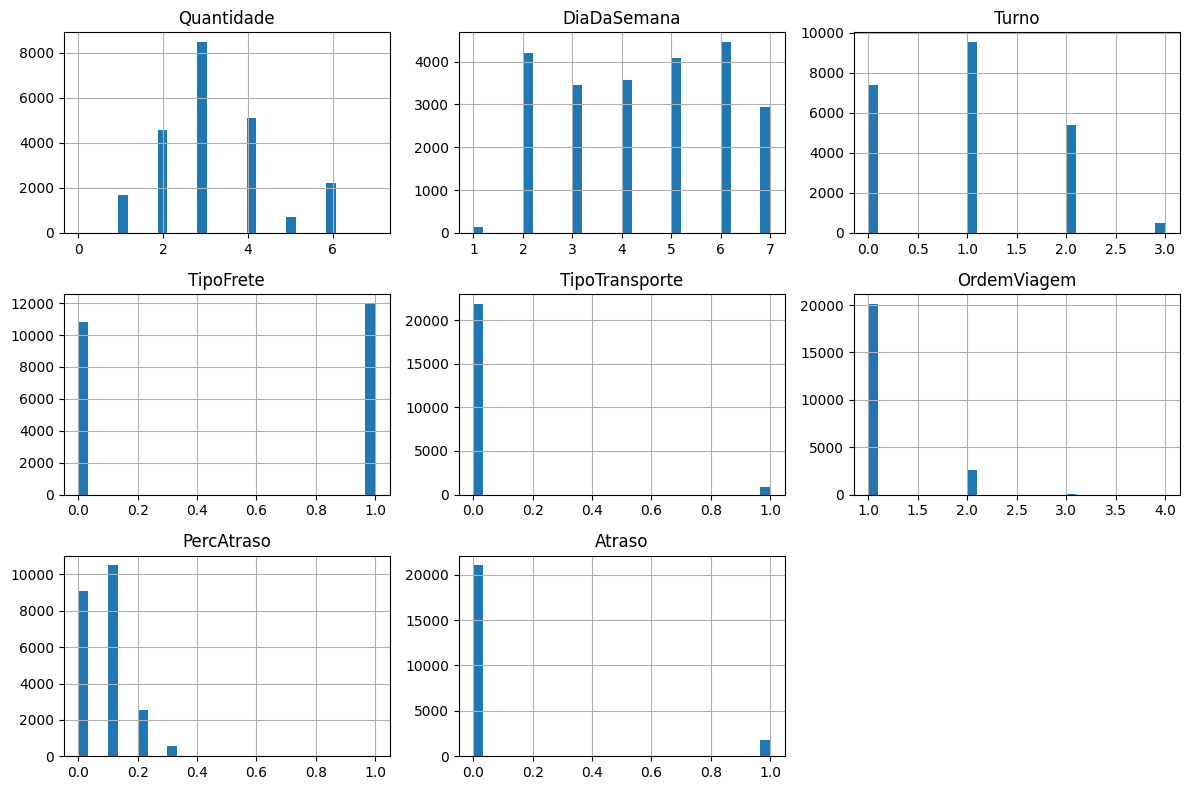

In [465]:
# Exibe os histogramas de todas as variáveis numéricas
print("\nHistograma do dataset:\n")
dataset.hist(bins=30, figsize=(12,8), layout=(3,3), sharex=False, sharey=False)
plt.tight_layout()
plt.show()


### 4.3 Análise estatística com boxplot

Nessa etapa é feita uma análise da distribuição estatística das variáveis. O boxplot permite essa análise de forma visual, enquanto o comando 'describe' o faz de forma tabular.

Aqui também é possível verificar que os valores estão dentro do esperado, mas que os campos 'TipoTransporte' e 'OrdemViagem' estão muito concentrados num único ponto.





Boxplot dos atributos numéricos


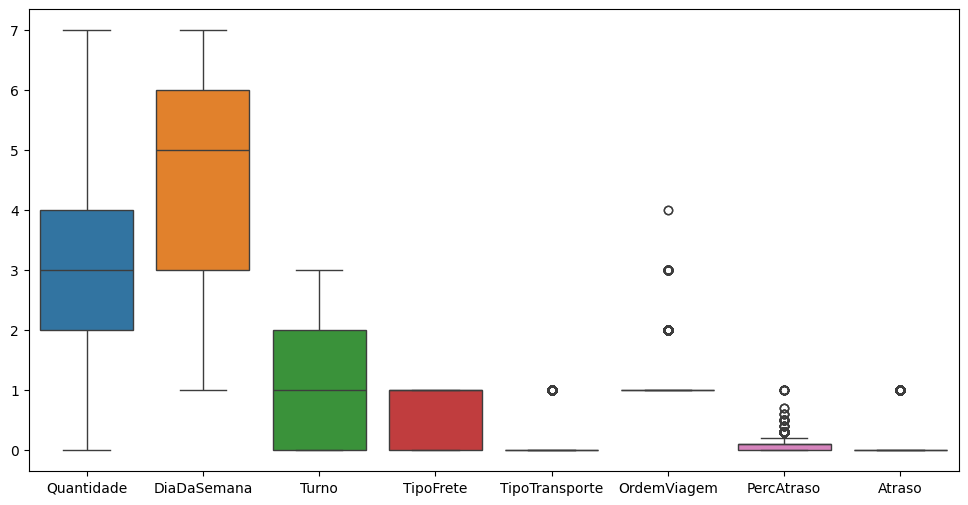


Sumário estatístico do dataset:



,Quantidade,DiaDaSemana,Turno,TipoFrete,TipoTransporte,OrdemViagem,PercAtraso,Atraso
count,22807.000000,22807.000000,22807.000000,22807.000000,22807.000000,22807.000000,22807.000000,22807.000000
mean,3.228132,4.419783,0.955102,0.525058,0.040470,1.119569,0.078108,0.077652
std,1.293879,1.697130,0.802140,0.499383,0.197063,0.334839,0.081998,0.267628
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,3.000000,5.000000,1.000000,1.000000,0.000000,1.000000,0.100000,0.000000
75%,4.000000,6.000000,2.000000,1.000000,0.000000,1.000000,0.100000,0.000000
max,7.000000,7.000000,3.000000,1.000000,1.000000,4.000000,1.000000,1.000000


In [466]:

# boxplot com Seaborn
print("\n")
print("Boxplot dos atributos numéricos")
plt.figure(figsize=(12,6))
sns.boxplot(data = dataset)
plt.show()

# exibe um sumário estatístico
print("\nSumário estatístico do dataset:\n")
dataset.describe()


### 4.4 Análise das correlações

Nessa etapa é usado o comando seaborn.heatmaps para criar mapas de calor mostrando a correlação entre as variáveis. Essa análise é importante para identificar possíveis redundâncias e relações entre as variáveis

Aqui é possível identificar que a variável com maior correlação com o target é o campo 'PercAtraso'

O campo 'Turno' possui a menor correlação. Apesar disso foi decidido manter.

Em relação à correlação entre variáveis, percebe-se que 'TipoFrete' e 'PercAtraso' possuem a mais alta correlação, porém não é alta o suficiente (>0.85) para ter que remover uma delas.

O campo 'TipoFrete' possui uma correlação negativa, ou seja, quanto maior o valor, menor o target.

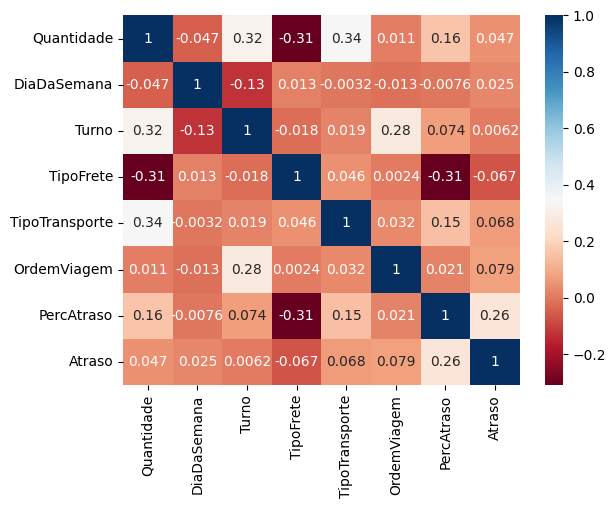

In [467]:

corr = dataset.corr(method='pearson') # utilizado o método pearson, pois é mais adequado a targets binários

# matriz de correlação com seaborn
sns.heatmap(corr, annot=True, cmap='RdBu');
plt.show()


## 5. Transformação dos dados
### 5.1. Balanceamento
No item 4.1 foi verificada o alto desbalanceamento do dataset, trazendo a necessidade de aplicar uma ou mais técnicas de balanceamento.

Foi escolhida a técnica de oversampling SMOTE (Syntetic Minority Oversampling Technique), já que a classe minoritária é muito pequena em relação à majoritária e o uso de undersampling poderia causar a perda de muitos dados.
O SMOTE foi aplicado somente em 50% das amostras majoritárias porque o desbalanceamento original é muito alto e o SMOTE poderia gerar muitos dados sintéticos, o que poderia levar a overfiting.

Como o dataset permaneceu desbalanceado, foi utilizado em conjunto a técnica do ajuste de pesos, a fim de atribuir maior peso à classe minoritária. Ela foi aplicada em alguns dos modelos analisados como LogisticRegression e RandomForest utilizando o parâmetro 'class_weight="balanced"'.

In [468]:
# Verifica a distribuição das classes antes
print("\nDistribuição das classes antes do SMOTE:\n")
print(dataset.groupby('Atraso').size())

# Separa as features do target
X = dataset.drop(columns=['Atraso'])
y = dataset['Atraso']

# Aplica o SMOTE somente em 50% do desbalanceamento
smote = SMOTE(sampling_strategy=0.7, random_state=seed)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Reconstrói o dataset balanceado
dataset_balanceado = pd.concat([X_resampled, y_resampled], axis=1)

# Verifica a distribuição das classes balanceadas
print("\nDistribuição das classes após SMOTE:\n")
print(dataset_balanceado.groupby('Atraso').size())



Distribuição das classes antes do SMOTE:

Atraso
0    21036
1     1771
dtype: int64

Distribuição das classes após SMOTE:

Atraso
0    21036
1    14725
dtype: int64


## 6. Separação em conjunto de treino e teste

Utilizada técnica de holdout com estratificação


In [469]:
test_size = 0.20 # tamanho do conjunto de teste

# Separação em conjuntos de treino e teste
array = dataset_balanceado.values
numCols = len(dataset_balanceado.columns)
X = array[:,0:numCols-1]
y = array[:,numCols-1].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

print("Treino:", X_train.shape, "| Teste:", X_test.shape)

Treino: (28608, 7) | Teste: (7153, 7)


## 7. Avaliação dos modelos

Como o dataset ainda está desbalanceado, mesmo após o balanceamento, a escolha da métrica é muito importante. 

O uso do scoring accuracy não é recomendado nesses casos, pois o modelo pode acertar quase tudo prevendo só "0" e ainda assim parecer "bom", mas não terá utilidade.

Nesse cenário, é melhor utilizar um scoring que leve em conta o desbalanceamento, como 'precision', 'recall' ou 'f1'.

O scoring precision minimiza os falsos positivos. Nesse estudo a precisão é importante para evitar o excesso de alertas falsos de atraso, o que poderia gerar ações indesejadas.

O recall minimiza os falsos negativos. Nesse estudo o recall é importante para que os casos reais de atraso sejam de fato detectados e as ações cabíveis sejam tomadas.

Foi escolhido o scoring 'f1', que é uma média harmônica entre precision e recall, uma vez que no problema em análise os falsos positivos e falsos negativos são igualmente problemáticos.

### 7.1. Validação cruzada
Foi utilizada a validação cruzada cross_val_score do scikit-learn para avaliar com a mesma métrica (f1) todos os modelos candidatos usando vários conjuntos de teste. Essa é uma validação mais confiável do que avaliar somente um conjunto de teste.

Foi utilizada a técnica **`StratifiedKFold`**, que é apropriada ao problema de classificação, utilizando k = 5 para o número de divisões.

LogisticRegression: 0.629 (0.007)
RandomForest: 0.740 (0.012)
Ridge: 0.623 (0.009)
KNN: 0.664 (0.015)
NaiveBayes: 0.513 (0.009)
SVM: 0.675 (0.006)
AdaBoost: 0.646 (0.011)
GradientBoosting: 0.663 (0.005)


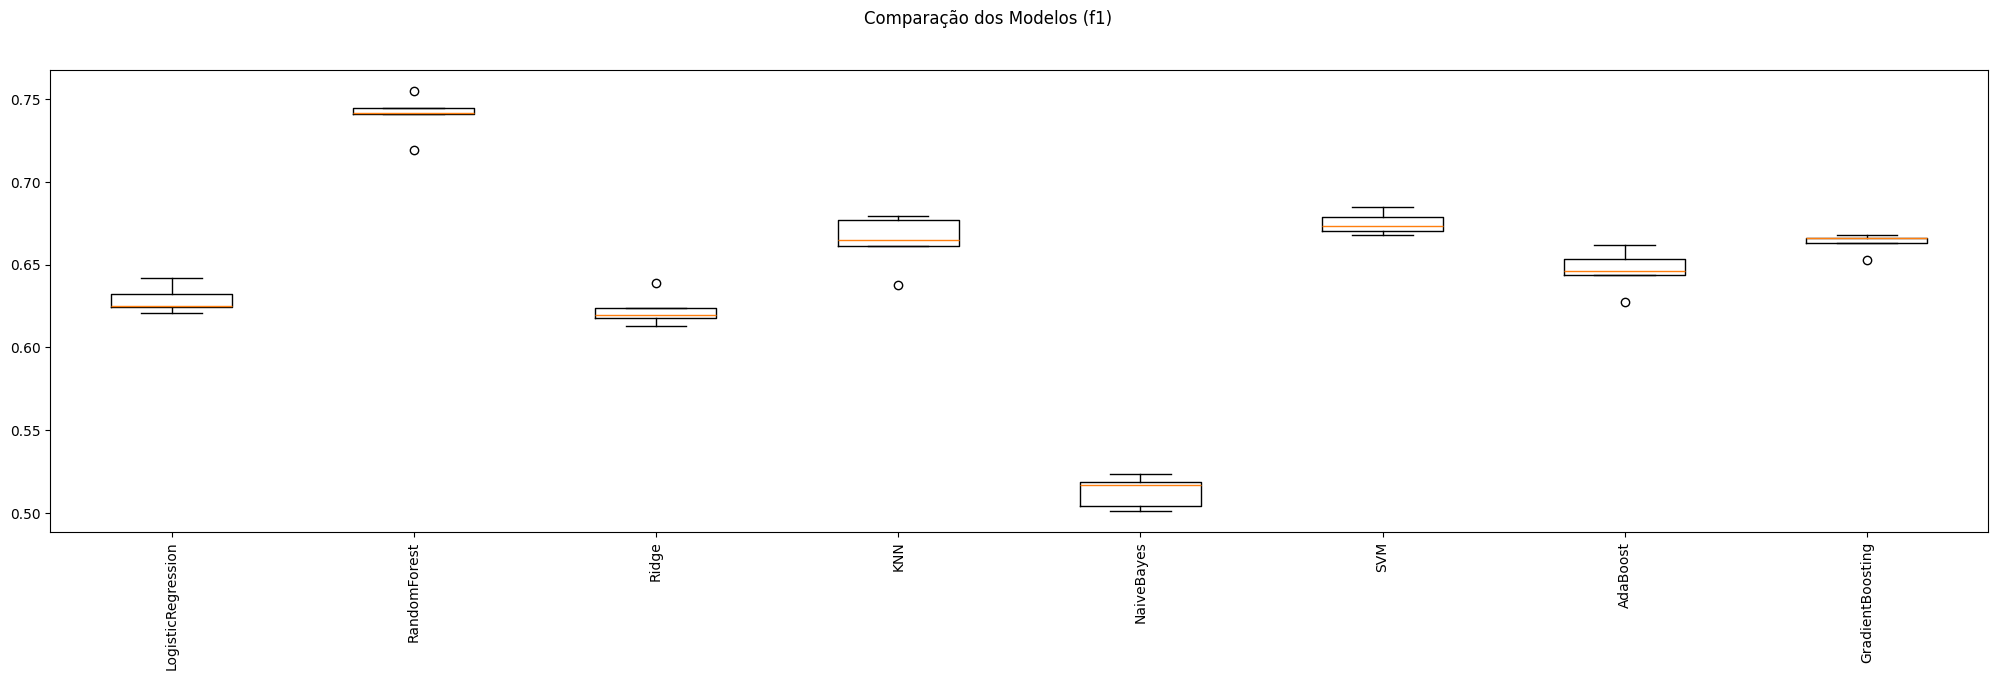

In [470]:

pipelines = criar_pipelines(['*'],'MinMaxScaler') # cria pipelines para todos os modelos disponíveis

scoring = 'f1'
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

results = []
names = []

# Executando os pipelines
for name, model in pipelines:     
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos (%s)' % scoring)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()


### 7.2. Otimização de Hiperparâmetros

A partir dos 2 modelos com melhor avaliação utilizando os parâmetros padrão, foi aplicada a técnica do GridSearchCV para fazer o tuning dos hiperparâmetros e melhorar o resultado dos modelos.

In [479]:

pipelines = criar_pipelines(['RandomForest','GradientBoosting']) # cria pipelines para os modelos escolhidos

best_params = {} # dicionário para armazenar os melhores parâmetros de cada modelo
# Prepara e executa o GridSearchCV
for name, model in pipelines:
    param_grid = get_hiperparametros(name)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # Armazena os melhores parâmetros num dicionário best_params para uso no posterior
    # Manipula o nome das chaves do dicionário, removendo o prefixo 'NomeDoModelo__' necessário para o GridSearchCV
    best_params[name] = {key.replace(name+'__', ''): value for key, value in grid.best_params_.items()}

    # imprime a melhor configuração
    print("%s - Melhor: %f usando %s" % (name, grid.best_score_, best_params[name]))

RandomForest - Melhor: 0.740668 usando {'max_features': 2, 'min_samples_split': 2, 'n_estimators': 200}
GradientBoosting - Melhor: 0.667876 usando {'max_features': 2, 'min_samples_split': 10, 'n_estimators': 200}


### 7.3. Comparação dos modelos com hiperparâmetros ajustados

O GridSearchCV conseguiu encontrar um novo conjunto de parâmetros que melhorou a parformance dos 2 modelos analisados.

Nessa etapa os 2 modelos foram treinados utilizando os hyperparâmetros ajustados e depois foram comparados com o baseline, que é o modelo dummy com estratégia 'stratified'. Essa estratégia escolhe o valor do target de maneira aleatória.

A comparação com o baseline mostrou que ambos foram melhores em todas as métricas.

A comparação entre os 2 modelos mostrou que o modelo 'RandomForest' foi melhor em todas as métricas em relação ao "GradientBosting'.

In [481]:
pipelines = criar_pipelines(['RandomForest','GradientBoosting'],"MinMaxScaler",best_params) # cria pipelines para os modelos escolhidos

results = {}

# Instanciando o normalizador MinMaxScaler
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Instanciando o classificador baseline (dummy)
baseline = DummyClassifier(strategy="stratified", random_state=seed)
t0 = time.time()
baseline.fit(X_train, y_train)
t1 = time.time()
y_pred = baseline.predict(X_test)
proba = baseline.predict_proba(X_test) if hasattr(baseline, "predict_proba") else None
results["baseline"] = avaliar_classificacao(y_test, y_pred, proba)
results["baseline"]["train_time_s"] = round(t1 - t0, 3)

# Executando os pipelines
for name, pipe in pipelines:
    t0 = time.time()
    pipe.fit(X_train, y_train)
    t1 = time.time()
    y_pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test) if hasattr(pipe, "predict_proba") else None
    results[name] = avaliar_classificacao(y_test, y_pred, proba)
    results[name]["train_time_s"] = round(t1 - t0, 3)

pd.DataFrame(results).T


,accuracy,recall,precision,f1_weighted,train_time_s
baseline,0.512652,0.512652,0.511756,0.512191,0.000
RandomForest,0.763456,0.763456,0.774912,0.765255,2.700
GradientBoosting,0.747379,0.747379,0.745340,0.743807,1.633


### 7.4. Análise da matriz de confusão

A matriz de confusão é uma ferramenta para avaliar o desempenho de modelos de classificação.
Ela mostra, em formato de tabela, a quantidade de previsões corretas e incorretas feitas pelo modelo, separando os resultados em categorias:

- Verdadeiros Positivos (VP): casos positivos corretamente classificados.
- Falsos Positivos (FP): casos negativos classificados como positivos.
- Verdadeiros Negativos (VN): casos negativos corretamente classificados.
- Falsos Negativos (FN): casos positivos classificados como negativos.

A matriz de confusão foi utilizada aqui para mostrar onde o modelo está acertando ou errando e os tipos de erro (por exemplo, se o modelo está errando mais ao prever atrasos ou não atrasos). 

Ao comparar os 2 modelos, vê-se que o RandomForest possui mais falsos positivos do que o Gradient Bosting, ou seja, veículos que foram detectados como atrasados de forma errada, porém essa diferença não é tão grande
Enquanto isso, a taxa de verdadeiros positivos do RandomForest foi muito boa, ou seja, o modelo conseguiu detectar 2356 atrasos e errou 589. Nesse aspecto o modelo foi muito melhor que o Gradient Bosting, que só detectou corretamente 1184 atrasos.

Essa análise da matriz corrobora a análise das métricas feita no item anterior, onde o Random Forest teve a melhor performance.

Diante disso, o melhor modelo encontrado foi o RandomForest, uma vez que teve a melhor taxa de verdadeiros positivos, sem uma taxa absurda de falso positivos.

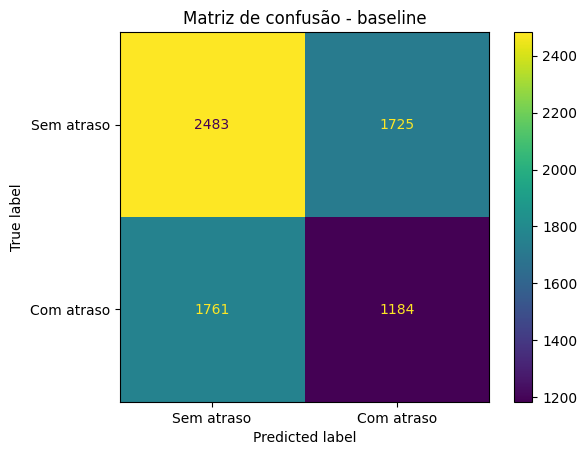

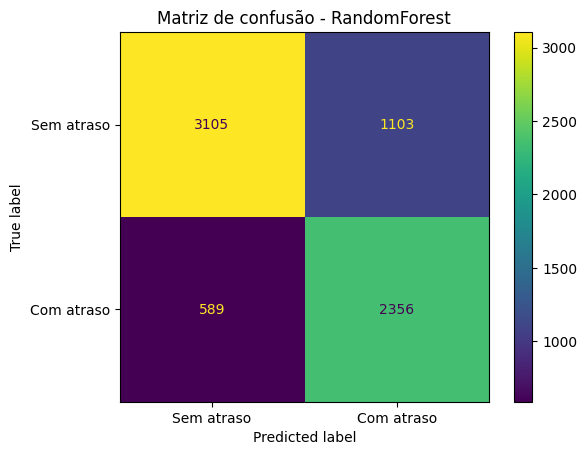

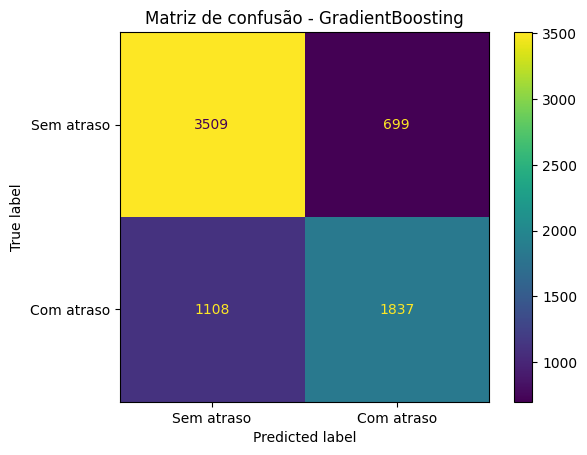

In [482]:
ConfusionMatrixDisplay.from_estimator(baseline, X_test, y_test, display_labels=['Sem atraso', 'Com atraso'])
plt.title("Matriz de confusão - " + "baseline")
plt.show()

for name, pipe in pipelines:   
    ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, display_labels=['Sem atraso', 'Com atraso'])
    plt.title("Matriz de confusão - " + name)
    plt.show()



## 8. Avaliação final

Diante dos resultados da análise das métricas e da análise das matrizes de confusão, o melhor modelo para o problema em questão é o Random Forest com os hiperparâmetros:
- class_weight='balanced'
- max_features=2
- n_estimators=200
- random_state=7

TODO: Descrever o método


Pipeline do melhor modelo:

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('RandomForest',
                 RandomForestClassifier(class_weight='balanced', max_features=2,
                                        n_estimators=200, random_state=7))])
              precision    recall  f1-score   support

           0       0.62      0.86      0.72      4208
           1       0.55      0.24      0.34      2945

    accuracy                           0.61      7153
   macro avg       0.59      0.55      0.53      7153
weighted avg       0.59      0.61      0.56      7153



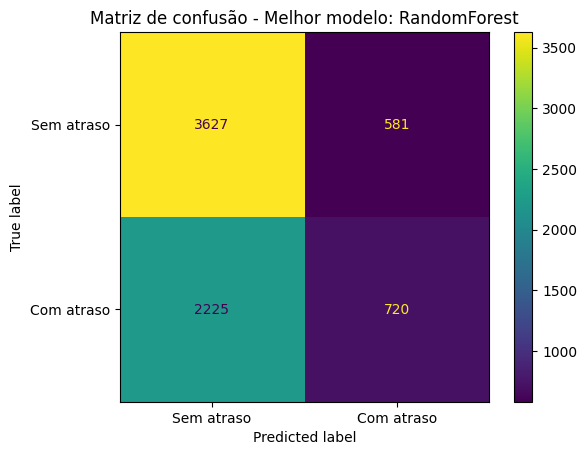

In [483]:
pipeline = criar_pipelines(['RandomForest'],"MinMaxScaler",best_params)
pipe_best_model = pipeline[0][1] # seleciona o primeiro modelo da lista (RandomForest)

# Exibe o pipeline do melhor modelo
print("\nPipeline do melhor modelo:\n")
print(pipe_best_model)

# Preparação do modelo com TODO o dataset
pipe_best_model.fit(X, y)
y_pred = pipe_best_model.predict(X_test)
print(classification_report(y_test, y_pred, labels=[0,1], zero_division=0))
try:
    ConfusionMatrixDisplay.from_estimator(pipe_best_model, X_test, y_test,display_labels=['Sem atraso', 'Com atraso'])
    plt.title("Matriz de confusão - Melhor modelo: RandomForest")
    plt.show()
except Exception as e:
    print("Não foi possível plotar a matriz de confusão:", e)


## 9. Simulando a aplicação do modelo em dados não vistos

Nessa etapa o modelo, que foi treinado com dados de janeiro a maio, foi aplicado para predizer registros totalmente novos, extraídos de julho/2025.
Vê-se que o modelo continuou a performar bem, com alta taxa de verdadeiros positivos e baixa taxa de falsos positivos.


Matriz de confusão:


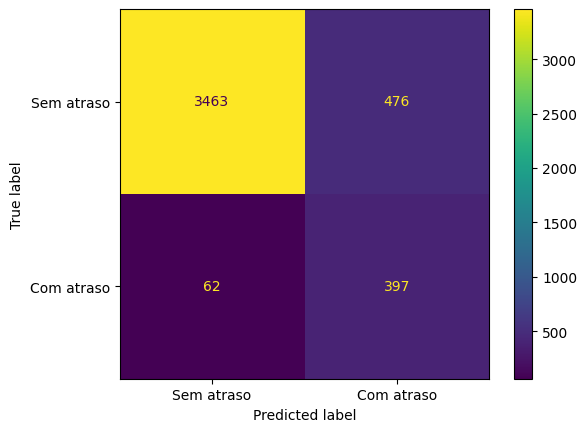


Relatório de Classificação:
              precision    recall  f1-score   support

  Sem atraso       0.98      0.88      0.93      3939
  Com atraso       0.45      0.86      0.60       459

    accuracy                           0.88      4398
   macro avg       0.72      0.87      0.76      4398
weighted avg       0.93      0.88      0.89      4398



In [484]:
# Carrega o dataset
#url = "https://github.com/marcos-vmiranda/pos-pucrj-mvp/blob/732bb70e9d90a4ebeac4e71f7ed4a645f6147fb6/atrasos_julho_tratados.csv?raw=true"
url = "c:/pos/MVP1/atrasos_junho_tratados.csv"
datasetTest = pd.read_csv(url, delimiter=',')
array = datasetTest.values
# Separa as features do target
numCols = len(datasetTest.columns)
X = array[:,0:numCols-1]
y = array[:,numCols-1]

# Faz as previsões com o pipeline do melhor modelo treinado
predictions = pipe_best_model.predict(X)

# Abre o arquivo pickle do modelo salvo
#with open("modelo_atrasos.pkl", "rb") as f:
#    modelo_carregado = pickle.load(f)
#predictions = modelo_carregado.predict(X)

# Exibe a matriz de confusão
print("\nMatriz de confusão:")
cm=confusion_matrix(y, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sem atraso', 'Com atraso'])
disp.plot()
plt.show()

# Exibe o relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y, predictions, target_names=['Sem atraso', 'Com atraso']))


## 10. Conclusões e próximos passos

A utilização de um modelo preditivo de classificação de atrasos numa base de distribuição de combustíveis utilizando os dados históricos de viagens se mostrou viável.

Os resultados mostraram que o modelo possui precisão suficiente para ser útil.

Como cada base possui um comportamento próprio e um conjunto de veículos específico, será necessário criar um modelo para cada base.

Como melhoria futura, esse projeto poderá ser integrado ao sistema de gestão operacional das bases, a fim de que seja utilizado para prever os atrasos dos veículos e possibilitar a otimização do fluxo operacional.

Para que os modelos se se mantenham atualizados, deverá ser implementado um job para treinamento automático a cada mês, a partir dos dados dos 5 meses anteriores.

Devido à necessidade de limitação do tempo de execução desse notebook, foi necessário reduzir o número de algoritmos avaliados. O mesmo se aplicou à etapa de tuning dos hiperparâmetros. Alguns precisaram ser suprimidos reduzir o tempo de execução do GridSerachCV. Sendo assim, num ambiente produtivo ainda existem algoritmos e hiperparâmetros a serem explorados e que otimizar ainda mais o modelo.



## 11. Salvando artefatos (modelos e pipeline)
Se o treinamento dos modelos demora mais de 3 minutos, recomendamos salvar o **modelo/pipeline** após o treinamento e depois apenas carregar o arquivo (ex: .pkl, .h5) salvo em outra célula, sem precisar treinar novamente.  

In [476]:
# Salva os modelos no formato pickle
import pickle

# Salva o melhor modelo
with open("modelo_atrasos.pkl", "wb") as f:
    pickle.dump(pipe_best_model, f)
